# WLS-EV Analysis

In [1]:
"""
KIT CRAM Seminar WS17/18
Algorithmic Design - Least squares estimates weighted by ex-ante return variance (WLS-EV)
"""

__author__ = 'Tobias Kuhlmann'

# Import own libraries
from variance_estimation import ExAnteVariance
from wlsev_model import Wlsev_model
from ols_model import OLS_model
import visualisation
from simon_ols_model import OLS
# import general packages
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline


/Users/tobias/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Preprocessing

### Read in log return data and variance

### Log returns

In [2]:
# Import price data and calc log returns
# --------------------------------------------------
es_50_prices = pd.read_csv('data/eurostoxx50_prices_eod.csv', parse_dates=True)
# set index, rename and check
es_50_prices['loctimestamp'] =pd.to_datetime(es_50_prices['loctimestamp'])
es_50_prices = es_50_prices.rename(columns={'loctimestamp': 'date'})
es_50_prices = es_50_prices.set_index('date')

#Log Returns
es_50_logret = es_50_prices
es_50_logret['logreturns'] = (np.log(es_50_prices['lastprice'] / es_50_prices['lastprice'].shift(1))).dropna()

del es_50_logret['lastprice']

### Volatility data

In [3]:
# Import vol data
# --------------------------------------------------
es_50_vol = pd.read_csv('data/es50_volatility.csv', parse_dates=True)
# Transform dates
es_50_vol['loctimestamp'] = pd.to_datetime(es_50_vol['loctimestamp'])
# Delete unnecessary columns
del es_50_vol['instrumentid']
# Calculate variance from vol
es_50_vol['variance'] = es_50_vol['volatility'] ** 2
del es_50_vol['volatility']
# set index, rename and check
es_50_vol = es_50_vol.rename(columns={'loctimestamp': 'date'})
es_50_vol = es_50_vol.set_index('date')

### Implied volatility data 

In [4]:
# Import implied volatility
# --------------------------------------------------
es_50_imp_vol = pd.read_csv('data/es50_implied_volatility.csv', parse_dates=True)
# Transform dates
es_50_imp_vol['loctimestamp'] = pd.to_datetime(es_50_imp_vol['loctimestamp'])
# Delete unnecessary columns
del es_50_imp_vol['instrumentid']
del es_50_imp_vol['maturity']
# Calculate implied variance from implied vol
es_50_imp_vol['implied_var'] = es_50_imp_vol['measure'] ** 2
del es_50_imp_vol['measure']
# set index, rename and check
es_50_imp_vol = es_50_imp_vol.rename(columns={'loctimestamp': 'date'})
es_50_imp_vol = es_50_imp_vol.set_index('date')

### Riskfree rate

In [5]:
# Import riskfree rate data
# --------------------------------------------------
rf = pd.read_csv('data/riskfree_rate.csv', parse_dates=True, sep=';')
# Transform dates
rf['loctimestamp'] = pd.to_datetime(rf['loctimestamp'])
# set index, rename and check
rf = rf.rename(columns={'loctimestamp': 'date'})
rf = rf.set_index('date')

### VRP data

In [6]:
# Import VRP data
# --------------------------------------------------
es_50_vrp = pd.read_csv('data/es50_vrp.csv', parse_dates=True)
# Transform dates
es_50_vrp['loctimestamp'] = pd.to_datetime(es_50_vrp['loctimestamp'])
# set index, rename and check
es_50_vrp = es_50_vrp.rename(columns={'loctimestamp': 'date'})
es_50_vrp = es_50_vrp.set_index('date')

### ERP data

In [7]:
# Calculate ERP from logrets and riskfree rate
# Take risk free rate maturity 7 (smallest maturity)
rf_mat7 = rf[rf['daystomaturity'] == 7]
# Calculate ERP = logrets - rf
es_50_erp = pd.DataFrame({'erp': (es_50_logret['logreturns'] - rf_mat7['riskfree']).dropna()})

### Q-Moments data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x111acda20>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1111f6ba8>], dtype=object)

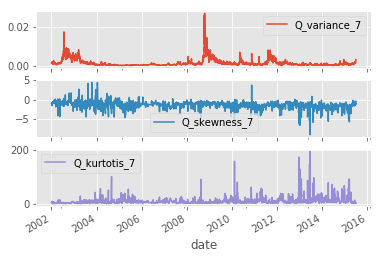

In [8]:
# Import Q-Moments data
# --------------------------------------------------
es_50_q = pd.read_csv('data/FiglewskiStandardizationEOD_DE0009652396D1_Qmoments.csv', parse_dates=True, sep = ';')
es_50_q.head(5)
# Transform dates
es_50_q['loctimestamp'] = pd.to_datetime(es_50_q['loctimestamp'])
# set index, rename and check
es_50_q = es_50_q.rename(columns={'loctimestamp': 'date'})
es_50_q = es_50_q.set_index('date')

# Delete unnecessary columns
del es_50_q['underlyingprice']
del es_50_q['underlyingforwardprice']
del es_50_q['Q_cubic']
del es_50_q['Q_quartic']

# Split maturities into seperate columns
es_50_q_7 = es_50_q[es_50_q['daystomaturity'] == 7]
es_50_q_7 = es_50_q_7.rename(columns={'Q_variance': 'Q_variance_7', 'Q_skewness': 'Q_skewness_7', 'Q_kurtosis': 'Q_kurtotis_7'})
del es_50_q_7['daystomaturity']

es_50_q_30 = es_50_q[es_50_q['daystomaturity'] == 30]
es_50_q_30 = es_50_q_30.rename(columns={'Q_variance': 'Q_variance_30', 'Q_skewness': 'Q_skewness_30', 'Q_kurtosis': 'Q_kurtotis_30'})
del es_50_q_30['daystomaturity']

es_50_q_60 = es_50_q[es_50_q['daystomaturity'] == 60]
es_50_q_60 = es_50_q_60.rename(columns={'Q_variance': 'Q_variance_60', 'Q_skewness': 'Q_skewness_60', 'Q_kurtosis': 'Q_kurtotis_60'})
del es_50_q_60['daystomaturity']

es_50_q_91 = es_50_q[es_50_q['daystomaturity'] == 91]
es_50_q_91 = es_50_q_91.rename(columns={'Q_variance': 'Q_variance_91', 'Q_skewness': 'Q_skewness_91', 'Q_kurtosis': 'Q_kurtotis_91'})
del es_50_q_91['daystomaturity']

es_50_q_182 = es_50_q[es_50_q['daystomaturity'] == 182]
es_50_q_182 = es_50_q_182.rename(columns={'Q_variance': 'Q_variance_182', 'Q_skewness': 'Q_skewness_182', 'Q_kurtosis': 'Q_kurtotis_182'})
del es_50_q_182['daystomaturity']

es_50_q_365 = es_50_q[es_50_q['daystomaturity'] == 365]
es_50_q_365 = es_50_q_365.rename(columns={'Q_variance': 'Q_variance_365', 'Q_skewness': 'Q_skewness_365', 'Q_kurtosis': 'Q_kurtotis_365'})
del es_50_q_365['daystomaturity']

es_50_q_7.plot(subplots = True)

### P-Moments data

In [9]:
# Import 5 min price data and calc log returns
# --------------------------------------------------
es_50_prices_5 = pd.read_csv('data/eurostoxx50_prices_5m.csv', parse_dates=True, sep=';')
# set index, rename and check
es_50_prices_5 = es_50_prices_5.rename(columns={'loctimestamp': 'date'})
es_50_prices_5['date'] = pd.to_datetime(es_50_prices_5['date'], errors='coerce')
es_50_prices_5 = es_50_prices_5.set_index('date')

#Log Returns
es_50_logret_5 = es_50_prices_5
es_50_logret_5['logreturns5min'] = np.log(es_50_prices_5['price'] / es_50_prices_5['price'].shift(1))
es_50_logret_5 = es_50_logret_5.dropna()

# Count of values per day
N = (es_50_logret_5.loc[(es_50_logret_5.index >= '2004-07-04 00:00:00') & (es_50_logret_5.index <= '2004-07-06 00:00:00')]).shape[0]

# Calculate moments after Amaya, Christoffersen, Jacobs, Vasquez (2015) - Does realized skewness predict equity returns
es_50_logret_5['logreturns_pow2'] = es_50_logret_5['logreturns5min'] ** 2
es_50_logret_5['logreturns_pow3'] = es_50_logret_5['logreturns5min'] ** 3
es_50_logret_5['logreturns_pow4'] = es_50_logret_5['logreturns5min'] ** 4

# group by date and sum up
helper = es_50_logret_5.groupby(es_50_logret_5.index.date).sum()

# Var 1 day = sum of intraday squared returns
es_50_P_1 = pd.DataFrame({'var1': helper['logreturns_pow2']})
# Skewness 1 day
es_50_P_1['skewness1'] = ( np.sqrt(N) * helper['logreturns_pow3']) / (es_50_P_1['var1'] ** (3 / 2) )
# Kurtosis 1 day
es_50_P_1['kurtosis1'] = N * helper['logreturns_pow4'] / (es_50_P_1['var1'] ** 2)

# Var 7 days ahead = sum of intraday squared returns
es_50_P_7 = pd.DataFrame({'var7': helper['logreturns_pow2'].rolling(7).sum().shift(-6)})
# Skewness 7 days
es_50_P_7['skewness7'] = (np.sqrt(N * 7) * helper['logreturns_pow3'].rolling(7).sum().shift(-6)) / (es_50_P_7['var7'] ** (3 / 2) )
# Kurtosis 7 days
es_50_P_7['kurtosis7'] = (N* 7 * helper['logreturns_pow4'].rolling(7).sum().shift(-6)) / (es_50_P_7['var7'] ** 2)

# Var 30 days ahead = sum of intraday squared returns
es_50_P_30 = pd.DataFrame({'var30': helper['logreturns_pow2'].rolling(30).sum().shift(-29)})
# Skewness 7 days
es_50_P_30['skewness30'] = (np.sqrt(N * 30) * helper['logreturns_pow3'].rolling(30).sum().shift(-29)) / (es_50_P_30['var30'] ** (3 / 2) )
# Kurtosis 7 days
es_50_P_30['kurtosis30'] = (N * 30 * helper['logreturns_pow4'].rolling(30).sum().shift(-29)) / (es_50_P_30['var30'] ** 2)

# Var 60 days ahead = sum of intraday squared returns
es_50_P_60 = pd.DataFrame({'var60': helper['logreturns_pow2'].rolling(60).sum().shift(-59)})
# Skewness 7 days
es_50_P_60['skewness60'] = (np.sqrt(N * 60) * helper['logreturns_pow3'].rolling(60).sum().shift(-59)) / (es_50_P_60['var60'] ** (3 / 2) )
# Kurtosis 7 days
es_50_P_60['kurtosis60'] = (N * 60 * helper['logreturns_pow4'].rolling(60).sum().shift(-59)) / (es_50_P_60['var60'] ** 2)

# Var 91 days ahead = sum of intraday squared returns
es_50_P_91 = pd.DataFrame({'var91': helper['logreturns_pow2'].rolling(91).sum().shift(-90)})
# Skewness 7 days
es_50_P_91['skewness91'] = (np.sqrt(N * 91) * helper['logreturns_pow3'].rolling(60).sum().shift(-90)) / (es_50_P_91['var91'] ** (3 / 2) )
# Kurtosis 7 days
es_50_P_91['kurtosis91'] = (N * 91 * helper['logreturns_pow4'].rolling(91).sum().shift(-90)) / (es_50_P_91['var91'] ** 2)

# Var 182 days ahead = sum of intraday squared returns
es_50_P_182 = pd.DataFrame({'var182': helper['logreturns_pow2'].rolling(182).sum().shift(-181)})
# Skewness 7 days
es_50_P_182['skewness182'] = (np.sqrt(N * 182) * helper['logreturns_pow3'].rolling(182).sum().shift(-181)) / (es_50_P_182['var182'] ** (3 / 2) )
# Kurtosis 7 days
es_50_P_182['kurtosis182'] = (N * 182 * helper['logreturns_pow4'].rolling(182).sum().shift(-181)) / (es_50_P_182['var182'] ** 2)

# Var 365 days ahead = sum of intraday squared returns
es_50_P_365 = pd.DataFrame({'var365': helper['logreturns_pow2'].rolling(365).sum().shift(-364)})
# Skewness 7 days
es_50_P_365['skewness365'] = (np.sqrt(N * 365) * helper['logreturns_pow3'].rolling(365).sum().shift(-364)) / (es_50_P_365['var365'] ** (3 / 2) )
# Kurtosis 7 days
es_50_P_365['kurtosis365'] = (N * 365 * helper['logreturns_pow4'].rolling(365).sum().shift(-364)) / (es_50_P_365['var365'] ** 2)

/Users/tobias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tobias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tobias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

### Fama-French data

In [10]:
# Import Fama French Factors
# --------------------------------------------------
# HML and SMB
es_50_ff = pd.read_csv('data/FamaFrench_Europe_3_Factors_Daily.csv', parse_dates=True, skiprows=6)
es_50_ff = es_50_ff.rename(columns={'Unnamed: 0': 'date'})
es_50_ff['date'] = pd.to_datetime(es_50_ff['date'], format = '%Y%m%d')
es_50_ff = es_50_ff.set_index('date')

# Momentum Factor
es_50_ff2 = pd.read_csv('data/FamaFrench_Europe_MOM_Factor_Daily.csv', parse_dates=True, skiprows=6)
es_50_ff2 = es_50_ff2.rename(columns={'Unnamed: 0': 'date'})
es_50_ff2['date'] = pd.to_datetime(es_50_ff2['date'], format = '%Y%m%d')
es_50_ff2 = es_50_ff2.set_index('date')

# Join and drop na's
es_50_ff = es_50_ff.join(es_50_ff2).dropna()



## Join data for correct dates

In [11]:
# Join data
data_all = pd.concat([es_50_logret, es_50_vol, es_50_imp_vol, es_50_vrp, es_50_erp, es_50_q_7, es_50_q_30, es_50_q_60, es_50_q_91, es_50_q_182, es_50_q_365, es_50_P_7, es_50_P_30, es_50_P_60, es_50_P_91, es_50_P_182, es_50_P_365, es_50_ff], join='inner', axis=1).dropna()
data_wop = pd.concat([es_50_logret, es_50_vol, es_50_imp_vol, es_50_vrp, es_50_erp, es_50_q_7, es_50_q_30, es_50_q_60, es_50_q_91, es_50_q_182, es_50_q_365, es_50_ff], join='inner', axis=1).dropna()
data_pq = pd.concat([es_50_q_7, es_50_q_30, es_50_q_60, es_50_q_91, es_50_q_182, es_50_q_365, es_50_P_7, es_50_P_30, es_50_P_60, es_50_P_91, es_50_P_182, es_50_P_365], join='inner', axis=1).dropna()

#data_wop.plot(subplots=True)
print(data_all.shape)
print(data_wop.shape)
print(data_pq.shape)

print(data_wop.columns)

(0, 46)
(1947, 28)
(433, 36)
Index(['logreturns', 'variance', 'implied_var', 'vrp', 'erp', 'Q_variance_7',
       'Q_skewness_7', 'Q_kurtotis_7', 'Q_variance_30', 'Q_skewness_30',
       'Q_kurtotis_30', 'Q_variance_60', 'Q_skewness_60', 'Q_kurtotis_60',
       'Q_variance_91', 'Q_skewness_91', 'Q_kurtotis_91', 'Q_variance_182',
       'Q_skewness_182', 'Q_kurtotis_182', 'Q_variance_365', 'Q_skewness_365',
       'Q_kurtotis_365', 'Mkt-RF', 'SMB', 'HML', 'RF', 'WML'],
      dtype='object')


# Model and Analysis

## Estimate Ex ante Variance

Variance Estimation Object initialized!
Variance Estimation begins!
Variance Estimation Results
                            OLS Regression Results                            
Dep. Variable:          var_daily_est   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     421.1
Date:                Fri, 23 Feb 2018   Prob (F-statistic):          1.18e-260
Time:                        15:30:35   Log-Likelihood:                 2080.6
No. Observations:                1925   AIC:                            -4151.
Df Residuals:                    1920   BIC:                            -4123.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

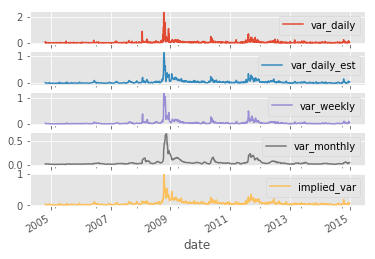

In [12]:
# Model and Analysis
# ==================================================
#
# 1. Estimate (sigma_t)2, the (ex ante) conditional variance of next-period unexpected returns epsilon_(t+1)
# using a HAR-RV (Hierachical Autoregressive-Realized Variance) Model from Corsi (2009)
# ------------------------------------------------------------------------------------------------------------
# First, instantiate object
# no implied vol
ea_var_obj = ExAnteVariance(data_wop['variance'])
# implied vol exists
#ea_var_obj = ExAnteVariance(data_wop['variance'], data_wop['implied_var'])

# Estimate Variance
result = ea_var_obj.estimate_variance()
result = result.dropna()

# Join returns and estimated variance
wlsev_var_rets = es_50_logret.join(result).dropna()



## WLS-EV and benchmark estimations

### Regress returns on returns

##### Forecast horizon 1, 5 and 10

In [13]:
# 2. least squares estimates weighted by ex-ante return variance (WLS-EV) using Johnson (2016)
# ------------------------------------------------------------------------------------------------------------

for i in (1,5,10):
    # set forecast_horizon
    forecast_horizon = i

    # WLS-EV
    wlsev_obj = Wlsev_model(wlsev_var_rets['logreturns'][:-1].as_matrix(), wlsev_var_rets['logreturns'][1:].as_matrix(), wlsev_var_rets['vol_daily_est'][:-1].as_matrix(), forecast_horizon)
    wlsev_obj.fit()
    # OOS evaluation to get Rsquared
    wlsev_obj.evaluate()
    wlsev_obj.print_results()
    wlsev_obj.plot_results()
    # get data
    X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

    # OLS
    ols_obj = OLS_model(wlsev_var_rets['logreturns'][:-1].as_matrix(), wlsev_var_rets['logreturns'][1:].as_matrix(), forecast_horizon)
    ols_obj.fit()
    # OOS evaluation to get Rsquared
    ols_obj.evaluate()
    ols_obj.print_results()
    ols_obj.plot_results()
    # get data
    X, Y, y_ols = ols_obj.get_plot_data_ols()


    # Visualisation
    # ------------------------------------------------------------------------------------------------------------

    # time series plot
    visualisation.plot_results(X,Y,y_wlsev, y_ols)
    # scatter plot
    visualisation.plot_scatter(X,Y,y_wlsev, y_ols)


    # Get Simon's OLS estimation results
    if forecast_horizon == 1:
        ols_model = OLS(wlsev_var_rets['logreturns'][:-1].as_matrix(), wlsev_var_rets['logreturns'][1:].as_matrix())
        ols_model.fit()
        ols_model.printResults()

KeyError: 'vol_daily_est'

### Regress returns on VRP

##### Join vrp data with wls-ev log rets and ex ante variance

In [ ]:
es_50_vrp_rets_var = wlsev_var_rets.join(es_50_vrp).dropna()

##### forecast horizon months

In [ ]:
# set forecast_horizon
for i in (1,22,44, 66, 88):
    forecast_horizon = i

    # WLS-EV
    wlsev_obj = Wlsev_model(es_50_vrp_rets_var['vrp'][:-1].as_matrix(), es_50_vrp_rets_var['logreturns'][1:].as_matrix(), es_50_vrp_rets_var['vol_daily_est'][:-1].as_matrix(), forecast_horizon)
    wlsev_obj.fit()
    # OOS evaluation to get Rsquared
    wlsev_obj.evaluate()
    wlsev_obj.print_results()
    wlsev_obj.plot_results()
    # get data
    X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

    # OLS
    ols_obj = OLS_model(es_50_vrp_rets_var['vrp'][:-1].as_matrix(), es_50_vrp_rets_var['logreturns'][1:].as_matrix(), forecast_horizon)
    ols_obj.fit()
    # OOS evaluation to get Rsquared
    ols_obj.evaluate()
    ols_obj.print_results()
    # get data
    X, Y, y_ols = ols_obj.get_plot_data_ols()


    # Visualisation
    # ------------------------------------------------------------------------------------------------------------

    # time series plot
    visualisation.plot_results(X,Y,y_wlsev, y_ols)
    # scatter plot
    visualisation.plot_scatter(X,Y,y_wlsev, y_ols)

    # Get Simon's OLS estimation results
    if forecast_horizon == 1:
        ols_model = OLS(es_50_vrp_rets_var['vrp'][:-1].as_matrix(), es_50_vrp_rets_var['logreturns'][1:].as_matrix())
        ols_model.fit()
        ols_model.printResults()
        ols_obj.plot_results()

### Regress ERP on VRP

### Regress P-Moments on Q-Moments


### Regress Fama French Factors on Q-Moment